# Stochastic Invasion of Variants of Concern

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd

In [2]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew

In [3]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    # Set offspring distribution for the process - this defines the process
    def __init__(self, offspring):
        self.offspring = offspring
    
    # Set lifetimes for particles of each type
    def set_lifespans(self, omega):
        self.omega = omega
    
    # Set a vector of immigration rates
    def set_immigration(self, eta):    
        self.eta = eta
    
    # Build ODEs for the probability of extinction of a process that begins with a single particle of each type, 
    # excluding immigration. The final equation includes immigration and describes the full process starting with a
    # vector of n0 particles of each type and immigration at rate eta. 
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
#         method = methodclass(set_odes)
#         method.set_ic(u0=ics)
#         R, t = method.solver(time_points=t)
        R = sp.integrate.odeint(set_odes, ics, time).T
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = u@Omega(t) + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
#         method = methodclass(set_mean_odes)
#         method.set_ic(u0=ics)
#         M, t = method.solver(time_points=t)
        M = sp.integrate.odeint(set_mean_odes, ics, t).T
        return M
        

In [18]:
# Parameters to change 

ntypes = 16
nexposed = int(ntypes/2)

# Disease Parameters

Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype with roadmap changes
rtrans_variant = 1.5 # Relative transmissability of SA variant compared to wildtype
gamma = 0.4 # Recovery Rate
sigma = 0.3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
az_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to AstraZeneca vaccine
pfi_vac_uk = 1-0.7 # Reduction in transmission of UK variant due to Pfizer vaccine
new_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to new vaccine
az_vac_sa = 1-0.1 # Reduction in transmission of SA variant due to AstraZeneca vaccine
pfi_vac_sa = 1-0.5 # Reduction in transmission of SA variant due to Pfizer vaccine
new_vac_sa = 1-0.9 # Reduction in transmission of SA variant due to new vaccine
# vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

#k = -1 #1/10 # Dispersion Endo et al.

Tmax = 100 
num = 100
time = np.linspace(0, Tmax, num=num)

# Reduced transmissability for each type based on infection/vaccine immunity
# const_vec = np.array((1., sus_sa, az_vac_sa, az_vac_sa*sus_sa, pfi_vac_sa, pfi_vac_sa*sus_sa, new_vac_sa, new_vac_sa*sus_sa))
const_vec = np.array((1., sus_sa, az_vac_sa, np.min((az_vac_sa, sus_sa)), pfi_vac_sa, np.min((pfi_vac_sa, sus_sa)), new_vac_sa, np.min((new_vac_sa, sus_sa))))



# Vector of proportions of susceptibles for each type:


p_az = 0.32 # % vaccinated with AstraZeneca
p_pf = 0.17 # % vaccinated with Pfizer
p_new = 0 # % vaccinated with putative new vaccine (currently 0) 
p_no_vac = 1- p_az - p_pf - p_new # % unvaccinated

p_rec = 0.245 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_az, p_rec*p_az, p_sus*p_pf, p_rec*p_pf, p_sus*p_new, p_rec*p_new))



# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

cluster_im = 1
if not cluster_im:
    im =1/5.
    im_vec = np.zeros(ntypes)
    im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history
else:
    ntypes+=1
    cluster_size = 1/2.
    alpha = 1/2
    cluster_rate = 2.
    im_vec = np.zeros(ntypes)
    im_vec[-1] = cluster_rate
   


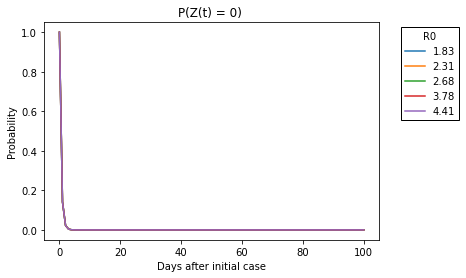

In [19]:
# Solve ODEs 

rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
showplot_rho = 1000
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
#     beta_vec = beta_SA * prop_vec
    RV = Reff*rtrans_variant

    
    omega_vec = sigma * np.ones(ntypes) 
    if cluster_im:
        omega_vec = np.append(omega_vec, cluster_size)
    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

#     beta_vec = beta_SA*np.ones(nexposed)
#     for i in range(0, len(vaccine_vec)):
#         beta_vec[2*i:2*i+2]*= vaccine_vec[i]
    
    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
#         sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*(1+(1/k)*(1-u[:nexposed]))**(-k))
        sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[:nexposed])


        for nex in range(0, nexposed):
            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        
        if cluster_im:
            pvec[-1] = np.sum((cluster_size*prop_vec)*const_vec*(1+(1/alpha)*(1-u[:nexposed]))**(-alpha))
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    ics = np.zeros(ntypes+1)
    ics[-1] = 1.
    n0vec = np.zeros(ntypes)
#     n0vec[0] = 1


    offspring = P
    outbreak = MTBP_extinct(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = True) # Solve ODEs for probabilities of extinction/zero
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[-1, :] # Take 0th row for qs, -1th row for rs

    plt.plot(time[:showplot_rho], rho_mat[r, :showplot_rho], label = str(np.round(RV, 2)))

plt.title("P(Z(t) = 0) " )
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
# plt.savefig("./pnocases_im=" + str(im) + "_beta=" + str(Reff_vec[0]*gamma*rtrans_variant)+ "_n0=0.pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
# plt.plot(time[:showplot_rho], np.exp(-1/5*time[:showplot_rho]), color = 'black')